 The dataset used for classification is from the source cited below. https://github.com/elnagara/HARD-Arabic-Dataset  

In [1]:
from fastai import *
from fastai.text import * 

def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
random_seed(42, True)

In [2]:
Path('data/hard/').mkdir(parents=True, exist_ok=True)
!cp '../input/balanced-reviews/balanced-reviews-utf8.tsv' data/hard/balanced-reviews.tsv

In [3]:
path=Path('data/hard/')
df_ar = pd.read_csv(path/'balanced-reviews.tsv', delimiter='\t')
df_ar.head() # the first review sounds positive but rating is 2 (-ve). Reviewer's choice!

,no,Hotel name,rating,user type,room type,nights,review
0,2,فندق 72,2,مسافر منفرد,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,“ممتاز”. النظافة والطاقم متعاون.
1,3,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...
2,16,فندق 72,5,زوج,-,أقمت ليلتين,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...
3,20,فندق 72,1,زوج,غرفة قياسية مزدوجة,أقمت ليلة واحدة,“استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...
4,23,فندق 72,4,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلتين,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...


In [4]:
df_ar = df_ar[['rating', 'review']] # we are interested in rating and review only
# code rating as +ve if > 3, -ve if less, no 3s in dataset 
df_ar['rating'] = df_ar['rating'].apply(lambda x: -1 if x < 3 else 1)
# rename columns to fit default constructor in fastai
df_ar.columns = ['label', 'text']
df_ar.head()

,label,text
0,-1,“ممتاز”. النظافة والطاقم متعاون.
1,1,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...
2,1,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...
3,-1,“استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...
4,1,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...


In [5]:
df_valid = df_ar.sample(21140, replace = False) # 20% for validation
df_valid['is_valid'] = True
df_train = df_ar.drop(df_valid.index)
df_train['is_valid'] = False

df_all = pd.concat([df_train, df_valid])
df_all.head()

,label,text,is_valid
0,-1,“ممتاز”. النظافة والطاقم متعاون.,False
1,1,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...,False
2,1,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...,False
3,-1,“استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...,False
4,1,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...,False


In [6]:
# write to csv (overwrites by default)
df_all.to_csv(path/'hard_text.csv', index=False)

In [7]:
df = pd.read_csv(path/'hard_text.csv')
df.head()

,label,text,is_valid
0,-1,“ممتاز”. النظافة والطاقم متعاون.,False
1,1,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...,False
2,1,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...,False
3,-1,“استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...,False
4,1,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...,False


In [8]:
Path('models/').mkdir(parents=True, exist_ok=True)
!cp -a '../input/model45_30_4/lm_best.pth' models/
!cp '../input/model45_30_4/itos.pkl' models/

In [9]:
Path('models/').absolute() # get absolute path od model files

PosixPath('/kaggle/working/models')

In [10]:
pretrained_fnames=['/kaggle/working/models/lm_best','/kaggle/working/models/itos']

In [11]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'hard_text.csv')
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'hard_text.csv', vocab=data_lm.train_ds.vocab, bs=64, num_workers=0)

In [12]:
data_lm.save()
data_clas.save()
data_lm = TextLMDataBunch.load(path)
data_clas = TextClasDataBunch.load(path, bs=64)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


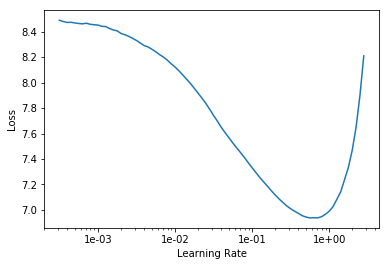

In [13]:
learn = language_model_learner(data_lm, pretrained_fnames=pretrained_fnames, drop_mult=0.1) # was .5
learn.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))#start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))
learn.recorder.plot(skip_end=10)

In [14]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy
1,4.781847,4.749305,0.279526


In [15]:
learn.unfreeze()
learn.fit_one_cycle(3, 2e-2)

epoch,train_loss,valid_loss,accuracy
1,4.475022,4.497181,0.300079
2,4.222795,4.302206,0.313552
3,3.838167,4.254705,0.317854


In [16]:
learn.predict("كان الاستقبال في الفندق", n_words=10)
# first amount of words (here 10), the next 10 target words (actual) and the ones predicted.
#learn.show_results(max_len = 10)

'كان الاستقبال في الفندق سيئ جداً وبالأخص الموظف سعيد ويتكلم الموظف تعتذر عن موعد'

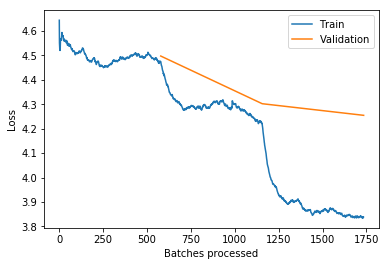

In [17]:
learn.save_encoder('ft_enc')
learn.recorder.plot_losses()

In [18]:
#classifier
learn_clas = text_classifier_learner(data_clas, drop_mult=0.5)
learn_clas.load_encoder('ft_enc')

In [19]:
data_clas.show_batch(2)

text,target
xxbos xxfld 1 “ فندق وادارة xxunk الزبون وفريق متعالي على لاشئ ” . كان لدي حجزين احدهم لاربع ايام والاخر بعدها بيوم لاربع ايام وحين وصل الفندق مع والدتي والعائله فاجأوني بأن الحجز الاول تم الغاءه دون التواصل معي او الاتصال من الفندق او من بوكينج وعذرهم xxunk لك ايميل xxunk مساء يوم الحجز وقد وصلت الفندق xxunk وقالوا العمليه معلقه ولكن حجزك الاخر للعائله الاخرى غدا تم اعتماده,-1
xxbos xxfld 1 “ خلافا xxunk ” . لا توجد زحمة في الفنندق . بمجرد وصولنا استغرق الموظف بالفندق وقت طويلا محاولا إيجاد حجزنا xxunk به عن طريق بوكنج ولم يجده إلا بعد ن اعطيته نسخة مطبوعة من حجزي . طالبني بالدفع مباشرة وقبل الدخول لغرفتنا فطلبت منه ان ادخل الحقائب xxunk صاحب التكسي الذي xxunk xxunk فوافق xxunk بعد ذلك رجعت xxunk منه سحب قيمة الحساب من بطاقتي البنكية,-1


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


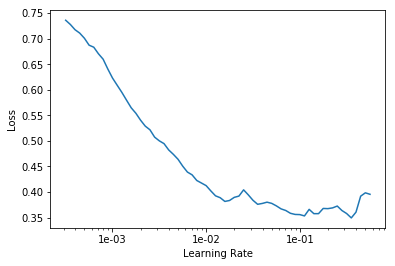

In [20]:
learn_clas.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))
learn_clas.recorder.plot(skip_end=10)

In [21]:
learn_clas.fit_one_cycle(1, 2e-3)

epoch,train_loss,valid_loss,accuracy
1,0.214791,0.143474,0.951372


In [22]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy
1,0.141145,0.118055,0.958893


In [23]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(3, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy
1,0.165351,0.121547,0.959082
2,0.134511,0.114191,0.961116
3,0.124157,0.114385,0.961447


In [24]:
print(learn_clas.validate())

[0.114384666, tensor(0.9614)]


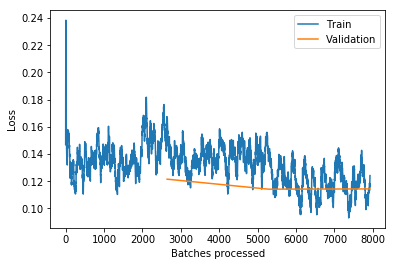

In [25]:
learn_clas.recorder.plot_losses()

In [26]:
learn_clas.show_results(rows=20)

text,target,prediction
xxbos xxfld 1 استثنائي . الفندق جدا جمييل للغايه ولكن هناك ملاحظه ولم يتم التجاوب معي للاسففي طلبي وحجزي عن طريق بوكينجطلبت غرفتين منفصلتين كل غرفة شخصين بالغين مع طفلين وهذا حسب الموجود في بوكينجبالرغم انتي ليس معي اطفال وليس بمرافقي في الغرفة الثانية اطفال وانما كنت ارغب لتكون الغرفتين كبيرتين وكان المرافق معي ضيف له مكانته وعرسان كبيران في السن وكنت قد رتبت لهما في غرفتي والتي لم يكن,1,1
xxbos xxfld 1 استثنائي . الفندق جدا جمييل للغايه ولكن هناك ملاحظه ولم يتم التجاوب معي للاسففي طلبي وحجزي عن طريق بوكينجطلبت غرفتين منفصلتين كل غرفة شخصين بالغين مع طفلين وهذا حسب الموجود في بوكينجبالرغم انتي ليس معي اطفال وليس بمرافقي في الغرفة الثانية اطفال وانما كنت ارغب لتكون الغرفتين كبيرتين وكان المرافق معي ضيف له مكانته وعرسان كبيران في السن وكنت قد رتبت لهما في غرفتي والتي لم يكن,1,1
xxbos xxfld 1 “ xxmaj the beach and xxunk are the only good things in this hotel ” . xxmaj the beach and xxunk are the only good things in this hotel . xxmaj the swimming pool is good as well . xxmaj the beach is safe and clean . الشيء الوحيد الجيد في هذا المنتجع هو شاطئ البحر و المنقذين حيث أنهم xxunk xxunk xxmaj first of all there,-1,-1
xxbos xxfld 1 استثنائي . اولا الفندق اول واحد انا سكنت فيه لان الفندق جديد ولم يتم افتتاحه xxunk سالت الاستقبال واخبروني بان الفندق جديد ولم يتم افتتاحه xxunk في شهر 10 / 2014 بالنسبه للسعر حاليا اتوقع سعره ممتاز xxunk مافي احد وحاطين اسعار جدا رخيصه لاني بصراحه اخذت جناح من 3 غرف xxunk 1200 لمدة يومين طبعا اتوقع السعر رخيص جدا عشان كما سبق وذكرت عدم xxunk في,1,1
xxbos xxfld 1 “ الفندق سيئ xxunk الكلمة ” . . اولا : موقع الفندق لا يوجد به شارع ، تقريبا مسافه كيلو ترابي . ٢- الاستقبال جدا جاف ، xxunk خدمه فاشلة . ٣- عندما ذهبنا للغرفه xxunk اغراضنا وعندما رجعنا وجدنا ان بعض من العصائر قد اخذت من الثلاجة ٤- اليوم الثاني عند تنظيف الغرفه ، الموظفين سرقو اغراضنا ( اشترينا اغراض بسيطة مثل xxunk وعصائر وبعض من,-1,-1
"xxbos xxfld 1 “ اسوأ معاملة في فندق xxmaj worst treatment at a xxmaj hotel ” . . xxmaj we were xxunk very xxunk by the staff upon arrival . xxmaj many guests were left waiting xxunk check - in time , and the worst part no one was xxunk xxunk or even xxunk the xxunk "" xxunk "" . xxmaj some said you had no booking ( when later",-1,-1
xxbos xxfld 1 ضعيف جداً. فندق فخم بس إدارة فاشلة و مزعجة و متعبة . 1 ) اتصلت قبل الوصول بساعة و أخبرتهم أنني سأصل فيرجى عدم التأخير مثل كل مرة على الرسبشن و طلبت تجهيز الأوراق للتوقيع و استلام الغرفة حيث أنني حاجز بالأنترنت .. فتفاجأت بتأخيري ساعة كاملة ... !!!2 ) لم يرسلوا العربة لنقل الأغراض من الباركن بالسيارة للغرفة فاضطريت لنقل الأغراض بنفسي على دفعتين من الباركن,-1,-1
xxbos xxfld 1 “ أسوأ تجربة فندقية ” . الموقع جيد .. ١- قمنا بحجز ( الجناح الملكي ) وحسب وصف الجناح يوجد به مطبخ وعند الوصول وجدنا مطبخ مكون من دواليب فقط دون فرن أو حتى xxunk وبدون حتى أدوات المطبخ من ملاعق وصحون ! ! فقط دواليب كبيرة فارغة تماما من أي شئ مع غلاية ماء وثلاجة . أخبرنا الفندق أن الفرن xxunk xxunk السلامة وهو ما xxunk,-1,-1
xxbos xxfld 1 مخيب للأمل . موقع الفندق وقربه من محطة القطار وكذلك المستشفى الذي أخذت زوجتي xxunk فيه . الإستقبال كا سيئا للغاية . كنت قد حجزت عن طريق موقعكم هذا وحددت xxunk عدد الغرف المطلوبة وعدد أفراد الأسرة وعلى xxunk تم تحديد التكلفة . الا أنني وعند وصولي للفندق فوجئت برفض الأستقبال تزويدي بأسرة أضافية الا أذا قمت بدفع مبالغ اضافية . لم يحل الموضوع الا بعد جدال,-1,-1
xxbos xxfld 1 “ عدم الاعتناء بالنزلاء ” . اعجبنى موقع الفندق بالنسبه للحرم فقط لا غير . لم xxunk xxunk : ا - عند سؤال عامل النظافه عن تغيير مفروشات السرائر اكد انه تم التغيير باخرى نظيفه و لكن للاسف كان xxunk لاننا وجدنا شعر xxunk كثير على جميع المفروشات xxunk و تم الطلب اكثر من مرة بتغيير المفروشات و اكد الاخ الموجود بالاستقبال انه على الفور سوف يرسل,-1,-1
